In [1]:
# Packages used for developing models, as well as processing information

from IPython import get_ipython
from IPython.display import display
# %%
from sklearn.svm import SVC
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from warnings import filterwarnings
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score,f1_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.compose import ColumnTransformer

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import LinearSVC
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB

import csv


filterwarnings('ignore')

#Processing Class

In [2]:
class processing_data:
  def __init__(self,base,label='Processing Dataset'):
    self.base = base
    self.label = label
    self.min_max_scaler = MinMaxScaler()


  def float_values(self, X, str_var):
        for column in str_var:
                try:
                    # Attempt to convert the column to float
                    # If the column is not already of type object (string),
                    # convert it first before applying string operations.
                    X[column] = X[column].astype(str).str.replace(',', '.').astype(float) # Use X instead of self.base
                except ValueError:
                    # If conversion fails, print a message and skip the column
                    print(f"Column '{column}' could not be converted to float. Skipping...")

        return X


  def int_values(self, X, str_var):
        for column in str_var:
                try:
                    # Attempt to convert the column to int
                    #X[column] = X[column].astype(int)
                    X[column]=pd.to_numeric(X[column], errors='coerce').astype(int) #changed column to X[column]
                except ValueError:
                    # If conversion fails, print a message and skip the column
                    print(f"Column '{column}' could not be converted to int. Skipping...")

        return X


  #if my target is a text I transform in dummy value
  #def target_variable(self,X,variavel):
  #  keys = list(self.base[variavel].unique())
  #  my_dict = {}

 #   for i, key in enumerate(keys):
 #     my_dict[key] = i
 #   self.base[variavel] = self.base[variavel].map(my_dict)
 #   return self.base,my_dict

  def target_variable(self,X,variavel,target, multiclass):
    if multiclass == False:
      self.base[variavel] = np.where(self.base[variavel]==target, 1, 0)
      return self.base
    else:
      keys = list(self.base[variavel].unique())
      my_dict = {}

      for i, key in enumerate(keys):
       my_dict[key] = i
      self.base[variavel] = self.base[variavel].map(my_dict)
      #with open('list_variables_markers.txt', 'w') as file:
      # file.write(my_dict)

      # open file for writing, "w" is writing
      w = csv.writer(open("output.csv", "w"))
      # loop over dictionary keys and values
      for key, val in my_dict.items():
      # write every key and value to file
        w.writerow([key, val])
      return self.base


  # transform in dummies some variables
  def dummy_df(self,X,dummies):
      X = pd.get_dummies(X, prefix=dummies, columns=dummies,dtype='int')
      return X

  def normalize_df(self,X,variavel):
    #Normalize the data
    column_to_move = X.pop(variavel)
    X[variavel] = column_to_move

    Lista_variaveis = X.columns[:-1]
    X=X.iloc[:,:-1]
    y=column_to_move.values
    X =pd.DataFrame(data=X, columns=Lista_variaveis)
    min_max_scaler =MinMaxScaler()
    X = self.min_max_scaler.fit_transform(X)
    return X,y,Lista_variaveis

  def impute_values(self, X, type_method):
        # Get the indices of columns with missing values within the impute_values method
        missing_cols_indices = [i for i, col in enumerate(X.columns) if X[col].isnull().any()]
        imputer = SimpleImputer(missing_values=np.nan, strategy=type_method)
        X_df = pd.DataFrame(X, columns = X.columns) # Use X.columns to ensure all columns are included

        # Impute missing values using these indices
        if missing_cols_indices:  # Check if there are any missing columns
            # Reshape the output of fit_transform to match the number of columns
            imputed_data = imputer.fit_transform(X_df[X_df.columns[missing_cols_indices]])
            # Create a DataFrame with the imputed values and correct columns
            #Instead of using X_df.columns[missing_cols_indices] I use X_df.columns[missing_cols_indices].to_list() for creating the dataframe
            imputed_df = pd.DataFrame(imputed_data, columns=X_df.columns[missing_cols_indices].to_list(), index=X_df.index) # Changed this line
            # Update the original DataFrame with the imputed values
            X_df.update(imputed_df)

        return X_df

#Models Class Multclass

In [37]:
class models_types:
  def __init__(self,X,y,Lista_variaveis,batch_size=None,epochs=None,cluster=None,model_tree=None):
    self.X = X
    self.y = y
    self.Lista_variaveis = Lista_variaveis
    self.batch_size = batch_size
    self.epochs = epochs
    self.cluster = cluster
    self.model_tree = model_tree
    self.min_max_scaler = MinMaxScaler()
    self.l_encode = LabelEncoder()
    self.l_encode.fit(np.unique(y))

  def neuro_model_multiclass(self): # Move this function outside __init__
    num_neu= len(self.Lista_variaveis)
    #targ=2
    ocult_neu=int((num_neu*(2/3))+2)
    # Get the number of unique classes in the target variable
    num_classes = self.y.shape[1]  # Assuming self.y is one-hot encoded
    neuro=tf.keras.models.Sequential([tf.keras.layers.Dense(num_neu,input_shape=(len(self.Lista_variaveis),)
                                                  ,activation='relu',kernel_initializer='he_normal'),
                              tf.keras.layers.Dropout(0.5),
                              tf.keras.layers.Dense(ocult_neu,activation='relu',kernel_initializer='he_normal'),
                              tf.keras.layers.Dropout(0.5),
                              # Change the output layer to have num_classes units
                              tf.keras.layers.Dense(num_classes, activation='softmax')])
    #Train setings
    neuro.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.CategoricalCrossentropy(), #or binary_crossentropy
                metrics=['accuracy'])
    # Return the compiled model instead of the fit history
    return neuro


  def cluster_model(self):
    kmeans = KMeans(n_clusters=self.cluster,init='k-means++',max_iter=300)
    return kmeans

  def tree_and_random_forest(self):
    #Decission Tree Model
    if self.model_tree == 'Decission Tree':
      tree_para = [{'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8,9,10,11,12,15,20]}]
      #GridSearchCV is a powerful tool for finding the best hyperparameters for
      #machine learning models. By using it properly and following best practices,
      #you can significantly improve the performance and accuracy of your models, saving time and effort in the process.

      clf = GridSearchCV(DecisionTreeClassifier(), tree_para, cv=3)
      clf.fit(self.X,self.y)
      print('Best Parameters',clf.best_params_['criterion'],clf.best_params_['max_depth'])
      arvore = DecisionTreeClassifier(criterion=clf.best_params_['criterion'],max_depth=clf.best_params_['max_depth'])
      #tree.plot_tree(arvore.fit(Xtrain,ytrain))
      return arvore

    else:
      #test parameters to check what would be the ideal number of trees and their depth
      tuned_parameters = [{'n_estimators': [20,50,100],
                          'max_depth': [4, 5, 6]}]
      #samples for use in cross_validation
      qt_cv = 3
      clf_rf = GridSearchCV(RandomForestClassifier(), tuned_parameters, cv= qt_cv, scoring='roc_auc')
      clf_rf.fit(self.X,self.y)
      RTArray = []
      print('Best Parameters',clf_rf.best_params_['n_estimators'],clf_rf.best_params_['max_depth'])
      clf_rf = RandomForestClassifier(
                    n_estimators = clf_rf.best_params_['n_estimators'],
                    max_depth = clf_rf.best_params_['max_depth'])

      #clf_rf.fit(Xtrain, ytrain)
      return clf_rf


  def knn_model(self):

    knn_para = [{'n_neighbors':[2,3,4,5],'p':[1,2]}]

    #KNN MODEL
    knn = GridSearchCV(KNeighborsClassifier(), knn_para, cv=3)
    knn.fit(self.X,self.y)
    print('Best Parameters',knn.best_params_)
    knn_f = KNeighborsClassifier(n_neighbors=knn.best_params_['n_neighbors'],p=knn.best_params_['p'])
    return knn_f

  def svm_model(self):
    svm_para = [{'kernel':['linear','poly','sigmoid'],
             'degree':[4,5]}]
    #Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.2,random_state=0)
    #svm = GridSearchCV(SVC(), svm_para, cv=3)
    #svm.fit(Xtrain,ytrain)
    #print(svm.best_params_)

    #svm_f = SVC(kernel=svm.best_params_['kernel'],degree=svm.best_params_['degree'])
    svm_f = SVC(kernel='rbf',degree=5,probability=True)
    return svm_f


  def models_metrics_neuro_multiclass(self, model, Xtrain, ytrain, Xtest, ytest,l_encode_train,l_encode_test):
    # Fit the model
    model.fit(Xtrain, ytrain, batch_size=self.batch_size, epochs=self.epochs)

    pred = model.predict(Xtest)
    pred_ = np.argmax(pred, axis=1) # Get the predicted class labels directly from 'pred'
    pred_ = l_encode_test.inverse_transform(pred_) # Use the encoder from 'encode_target'
    true_y =l_encode_test.inverse_transform(np.argmax(ytest, axis=1)) # Correctly decode ytest

    scores = model.evaluate(Xtest, ytest)
    print(f'Test Loss: {scores[0]}')
    print(f'Test Accuracy: {scores[1]}')
    print('\n')
    f1 = f1_score(pred_, true_y, average="weighted")
    print(f'F1 Score: {f1}')
    print('\n')

    # Calculate permutation feature importance using the scoring function
    result = permutation_importance(
        model, Xtest, true_y, n_repeats=10, random_state=0, scoring=self.scoring_fn_multclass
    )
    # Create a DataFrame to store the results
    feature_importances = pd.DataFrame(
        {
            "feature": Lista_variaveis,  # Assuming Lista_variaveis contains feature names
            "importance": result.importances_mean,
        }
    ).sort_values("importance", ascending=False)


    print('\n',feature_importances)

    print('Confussion Matrix')
    fig, ax = plt.subplots(figsize=(8, 5))
    cmp = ConfusionMatrixDisplay(confusion_matrix(true_y, pred_))
    cmp.plot(ax=ax)
    plt.show()

  def models_metrics_svm(self,model, Xtrain,ytrain,Xtest,ytest):
    #I can check the variables that were most relevant within my model
    perm_importance = permutation_importance(model, Xtest, ytest)

    feature_names = self.Lista_variaveis
    features = np.array(feature_names)

    sorted_idx = perm_importance.importances_mean.argsort()
    plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
    plt.xlabel("Permutation Importance")

  def scoring_fn_multclass(self, model, X, y):
    y_pred = model.predict(X, verbose=0)  # Get predicted probabilities
    y_pred_classes = np.argmax(y_pred, axis=1)  # Get predicted classes

    # Check if y is already in the correct shape
    if y.ndim == 2 and y.shape[1] > 1:  # If y is one-hot encoded
        y_true_classes = np.argmax(y, axis=1)
    else:  # If y is not one-hot encoded
        y_true_classes = y  # or use your desired method to get true classes

    return accuracy_score(y_true_classes, y_pred_classes)

  def models_metrics(self,model, Xtrain,ytrain,Xtest,ytest):
    model.fit(Xtrain, ytrain)

    # Get predicted probabilities for all classes
    probs = model.predict_proba(Xtest)

    # Iterate through each class to calculate and print ROC metrics
    for i in range(probs.shape[1]):
        fpr, tpr, thresholds = roc_curve(ytest, probs[:, i], pos_label=i)  # pos_label is important for multiclass
        print(f'\n ROC Metrics for Class {i}:')
        print(f'KS Validation: {stats.ks_2samp(fpr, tpr)[0] * 100.0:.2f}%')
        print(f'AUC: {auc(fpr, tpr) * 100:.2f}%')
        print(f'Probability Range: ({probs[:, i].max():.7f}, {probs[:, i].min():.7f})')

    probs_train = model.predict_proba(Xtrain)
    for i in range(probs_train.shape[1]):
        fpr, tpr, thresholds = roc_curve(ytrain, probs_train[:, i], pos_label=i)
        print(f'\n ROC Metrics for Class {i} (Training Data):')
        print(f'KS Development: {stats.ks_2samp(fpr, tpr)[0] * 100.0:.2f}%')
        print(f'AUC: {auc(fpr, tpr) * 100:.2f}%')
        print(f'Probability Range: ({probs_train[:, i].max():.7f}, {probs_train[:, i].min():.7f})')



#Application

In [4]:
Dataset =pd.read_csv ("breast_msk_2025_clinical_data.tsv", sep = '\t') # pd.read_csv('breast_cancer.csv',sep=';', on_bad_lines='skip')


In [5]:
Dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3879 entries, 0 to 3878
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Study ID                       3879 non-null   object 
 1   Patient ID                     3879 non-null   object 
 2   Sample ID                      3879 non-null   object 
 3   Cancer Type                    3879 non-null   object 
 4   Cancer Type Detailed           3879 non-null   object 
 5   Ethnicity                      3879 non-null   object 
 6   Fraction Genome Altered        3841 non-null   float64
 7   Sex                            3879 non-null   object 
 8   Gene Panel                     3879 non-null   object 
 9   Metastatic Site                2031 non-null   object 
 10  MSI Comment                    2385 non-null   object 
 11  MSI Score                      3786 non-null   float64
 12  MSI Type                       3788 non-null   o

In [6]:
Dataset.describe()

,Fraction Genome Altered,MSI Score,Mutation Count,Overall Survival (Months),Number of Samples Per Patient,Sample coverage
count,3841.000000,3786.000000,3784.000000,3871.000000,3879.000000,3879.000000
mean,0.281697,0.957810,6.096195,46.118694,1.469709,664.246971
std,0.189415,1.658486,6.619626,33.945864,0.723187,235.157279
min,0.000000,-1.000000,1.000000,0.000000,1.000000,12.000000
25%,0.129200,0.080000,3.000000,15.188875,1.000000,521.000000
50%,0.253800,0.440000,5.000000,40.109149,1.000000,669.000000
75%,0.406900,1.240000,7.000000,74.810139,2.000000,804.500000
max,0.981400,46.130000,179.000000,132.656081,6.000000,2610.000000


#Some Checks

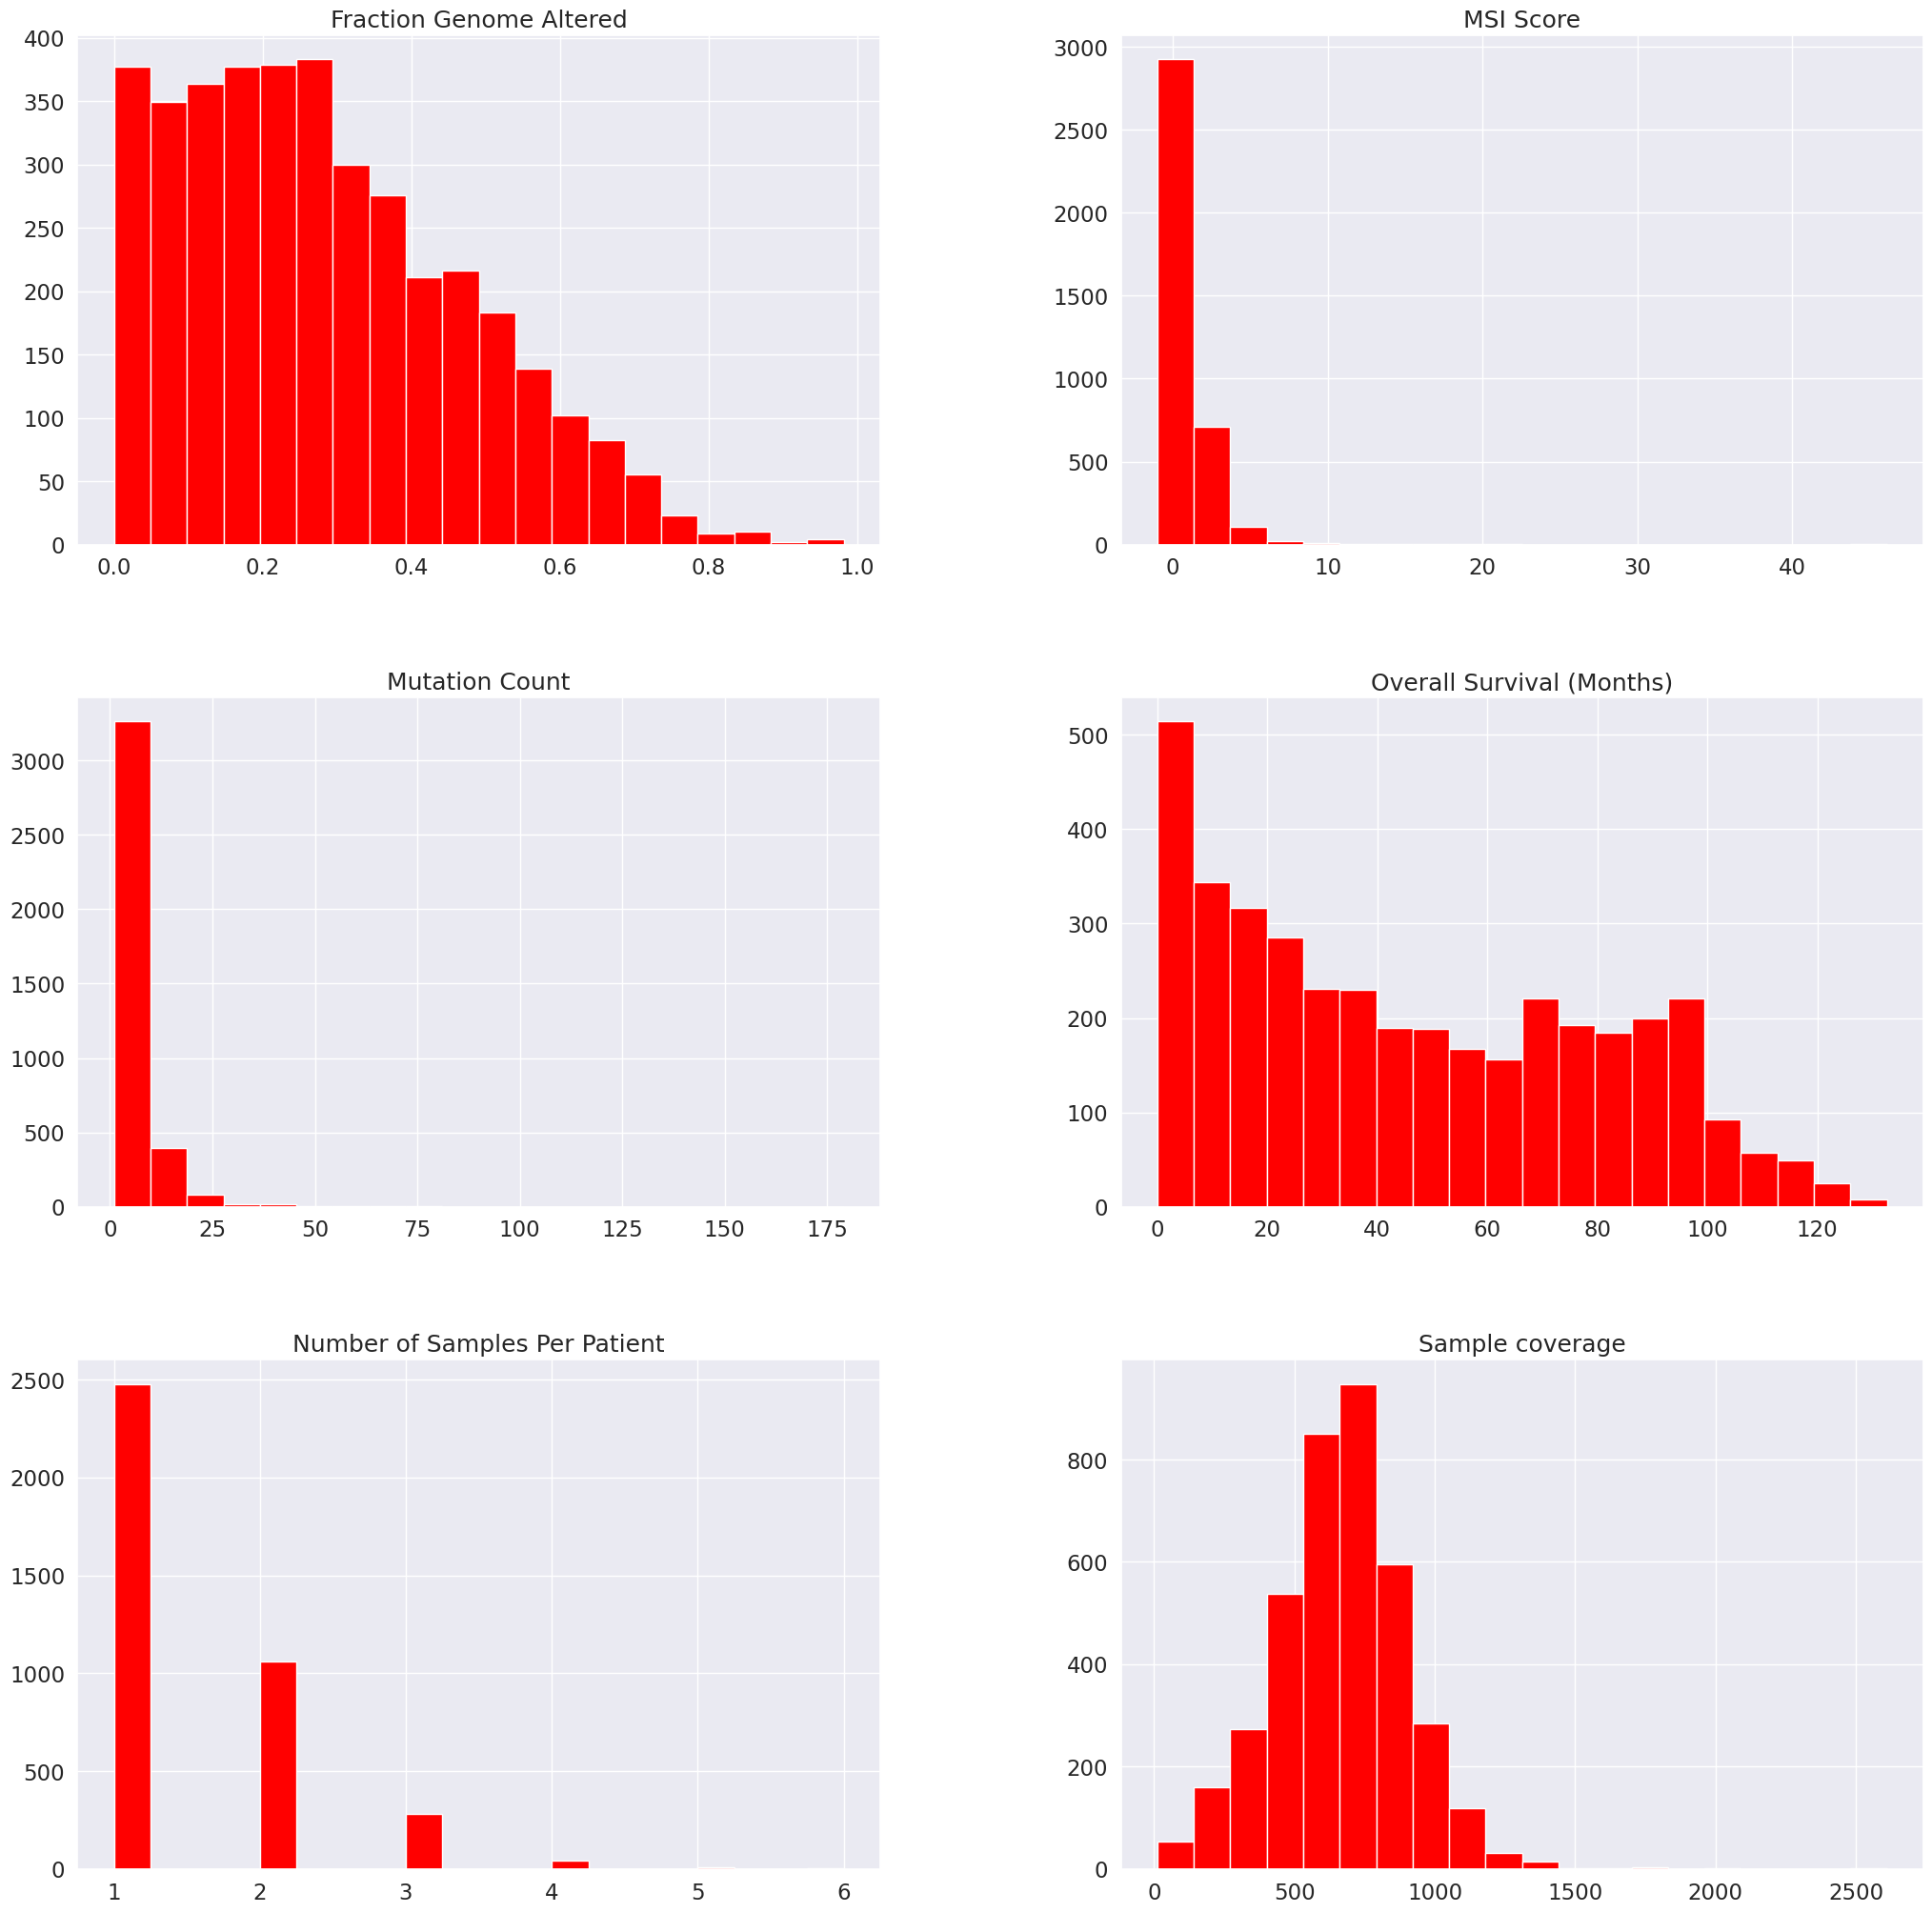

In [7]:
sns.set(font_scale=1.5,rc={'figure.figsize':(25,25)}) #usando a biblioteca sns posso verificar algumas distribuições dos meus dados
eixo=Dataset.hist(bins=20,color='red')

#Variable Processing

In [8]:
Dataset =pd.read_csv ("breast_msk_2025_clinical_data.tsv", sep = '\t')
percent_missing = Dataset.isnull().sum() * 100 / len(Dataset)
#List of variable to remove from my dataset, they are not importants to my model or has more than 20% of missing values
list_to_drop=['Overall Survival Status','MSI Type','Cancer Type',
              'Study ID','Patient ID','Sample ID','Ethnicity','Sex',
              'Primary Tumor Site','Race','Sample Class']
list_to_drop_percentage=percent_missing[percent_missing > 20].index
Dataset.drop(list_to_drop_percentage,axis=1,inplace=True)
Dataset.drop(list_to_drop,axis=1,inplace=True)

Dataset = Dataset.query('`Tumor Purity` != "default"')

processor = processing_data(base=Dataset.copy())
variavel='Cancer Type Detailed'
target='Breast Invasive Ductal Carcinoma'
type_method='mean'
dummies=['Sample Type','Somatic Status','Oncotree Code','Gene Panel']
var_int=['Tumor Purity']
multiclass=True

main_pipeline=Pipeline([
                        ('int_values', FunctionTransformer(processor.int_values,
                                            kw_args={'str_var': var_int},
                                            validate=False)),
                        ('target variable', FunctionTransformer(processor.target_variable,
                                            kw_args={'variavel': variavel, 'target':target, 'multiclass':multiclass},
                                            validate=False)),
                        ('Dummies', FunctionTransformer(processor.dummy_df,
                                            kw_args={'dummies': dummies},
                                            validate=False)),

                        ])

# Fit and transform the data using the pipeline
transformed_data = main_pipeline.fit_transform(Dataset)
X=processor.impute_values(transformed_data,type_method)
X,y,Lista_variaveis=processor.normalize_df(X,variavel)

Column 'Tumor Purity' could not be converted to int. Skipping...


#Check Metrics

Text(0.5, 1.0, 'Correlation Graph between Variables \n')

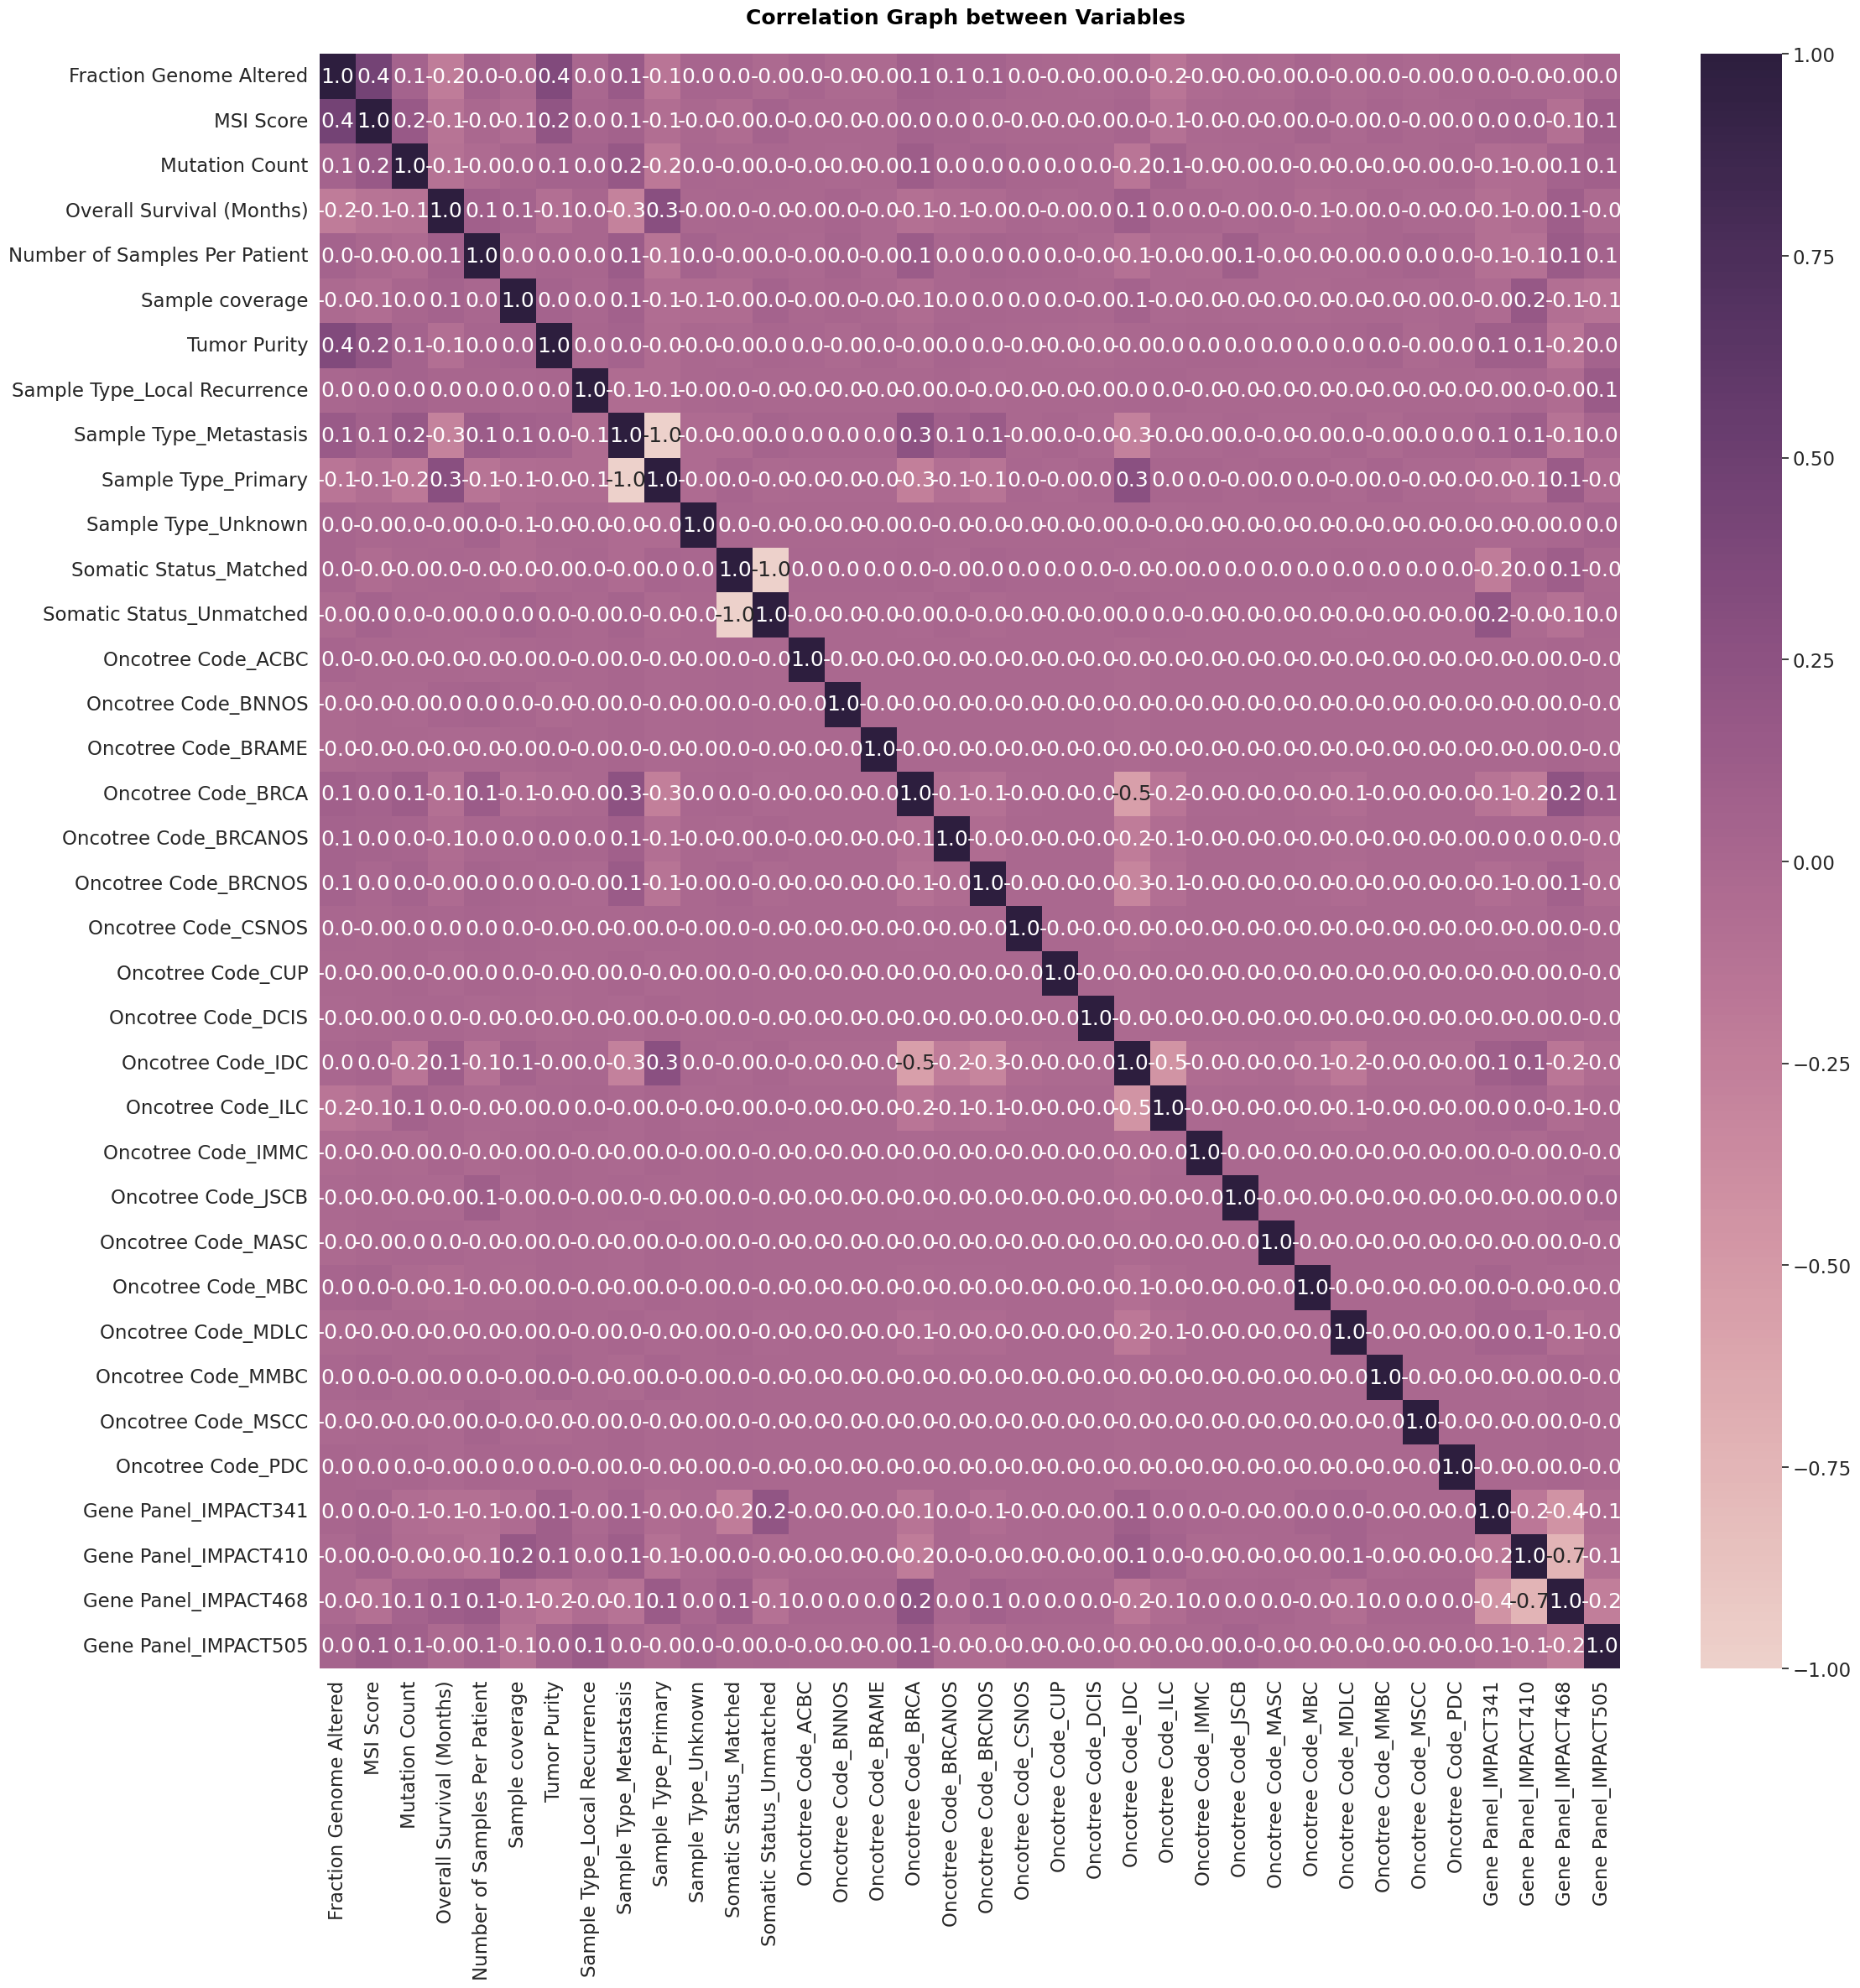

In [9]:
# Create correlation matrix
X_df = pd.DataFrame(X, columns=Lista_variaveis)  # Specify Lista_variaveis as columns
corr_mat = X_df.corr()

# Plot heatmap
plt.figure(figsize=(25, 25))
sns.heatmap(corr_mat, annot=True,
            fmt='.1f', cmap=sns.cubehelix_palette(200))
plt.title('Correlation Graph between Variables \n', weight="bold", color="#000000", fontsize=18)

Text(0.5, 1.0, 'Correlation Graph between Variables \n')

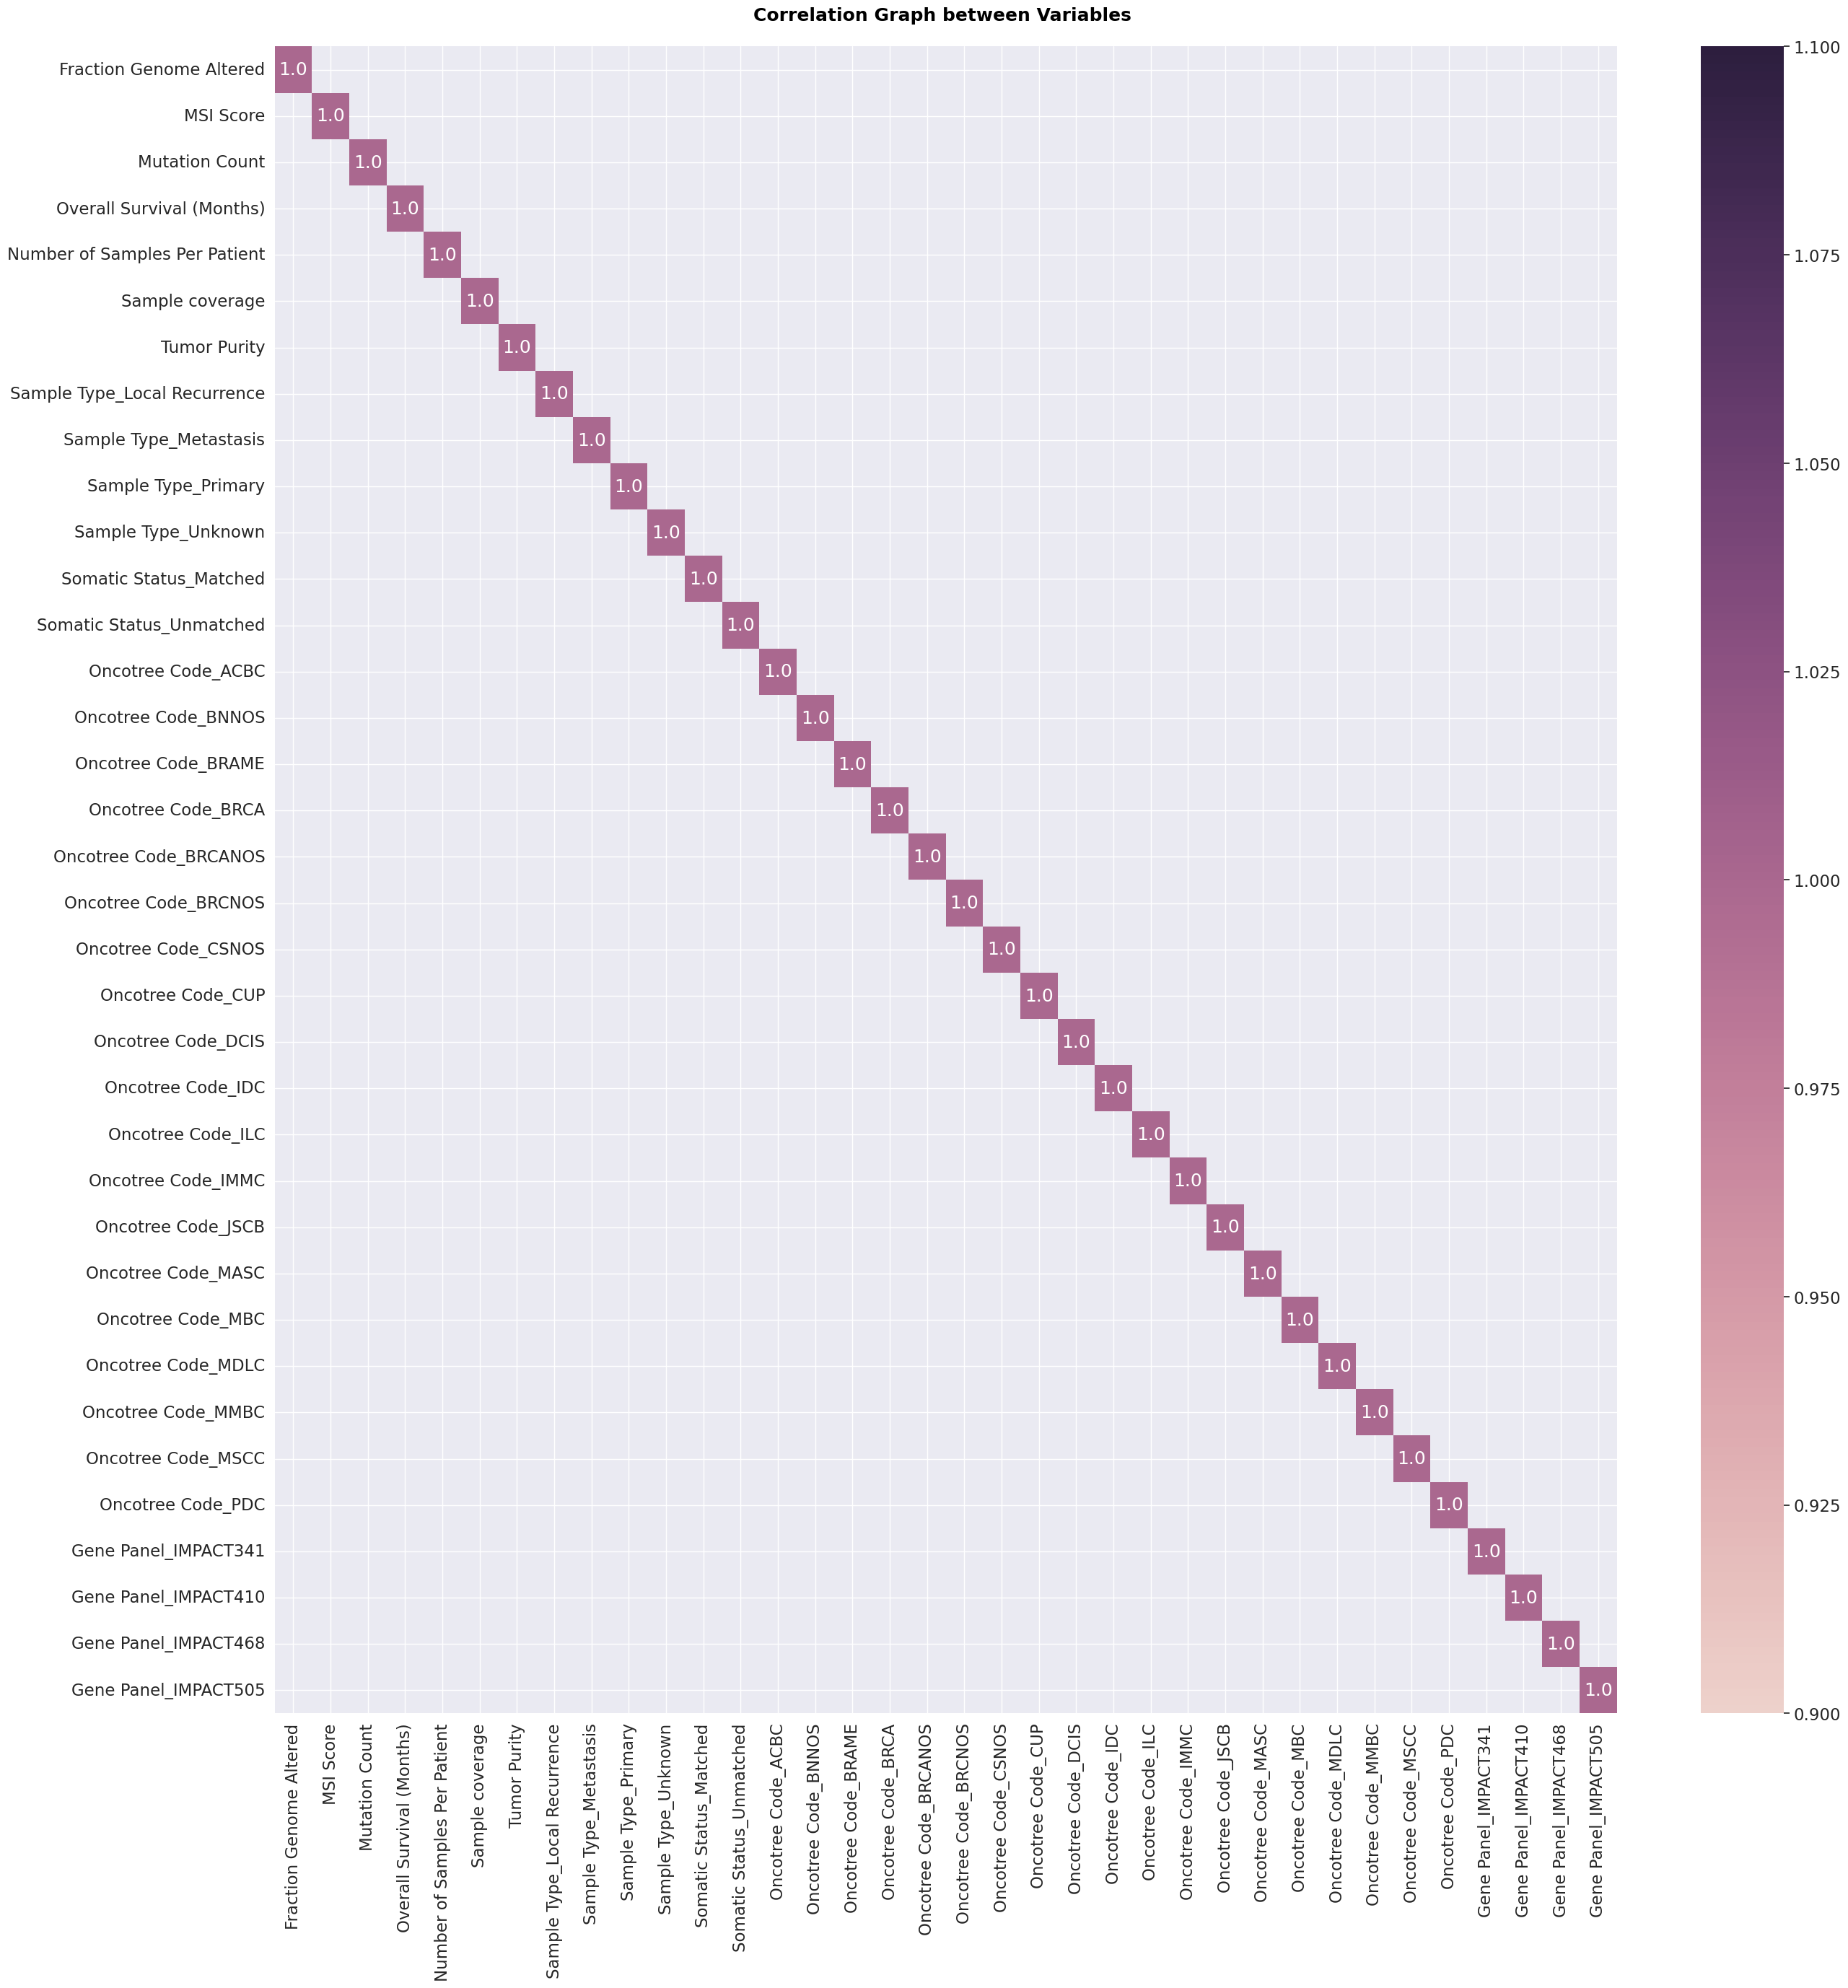

In [10]:
plt.figure(figsize=(30, 30))
sns.heatmap(corr_mat[corr_mat > 0.7], annot=True,
            fmt='.1f', cmap=sns.cubehelix_palette(200))
plt.title('Correlation Graph between Variables \n', weight="bold", color="#000000", fontsize=18)

In [11]:
import plotly.express as px

# Convert X to a pandas DataFrame with column names
X_df = pd.DataFrame(X, columns=Lista_variaveis)
X_df['target'] = y

# Create the histogram using the DataFrame and color mapping
histogram_diagnosis = px.histogram(
    X_df,
    x='target',
    color=X_df['target'],  # Map target values to colors
    title='Count Cases',
    text_auto=True,
)
histogram_diagnosis.show()

In [ ]:
counts = X_df['target'].value_counts(dropna=False)
counts.plot.pie(autopct='%1.1f%%')
plt.title('Percentage distribution of Cases')
plt.axis('equal')
plt.show()

In [21]:
import plotly.express as px
fig = px.pie(X_df, values='target', names='target', title='Percentage',color_discrete_sequence=px.colors.sequential.RdBu)
fig.show()

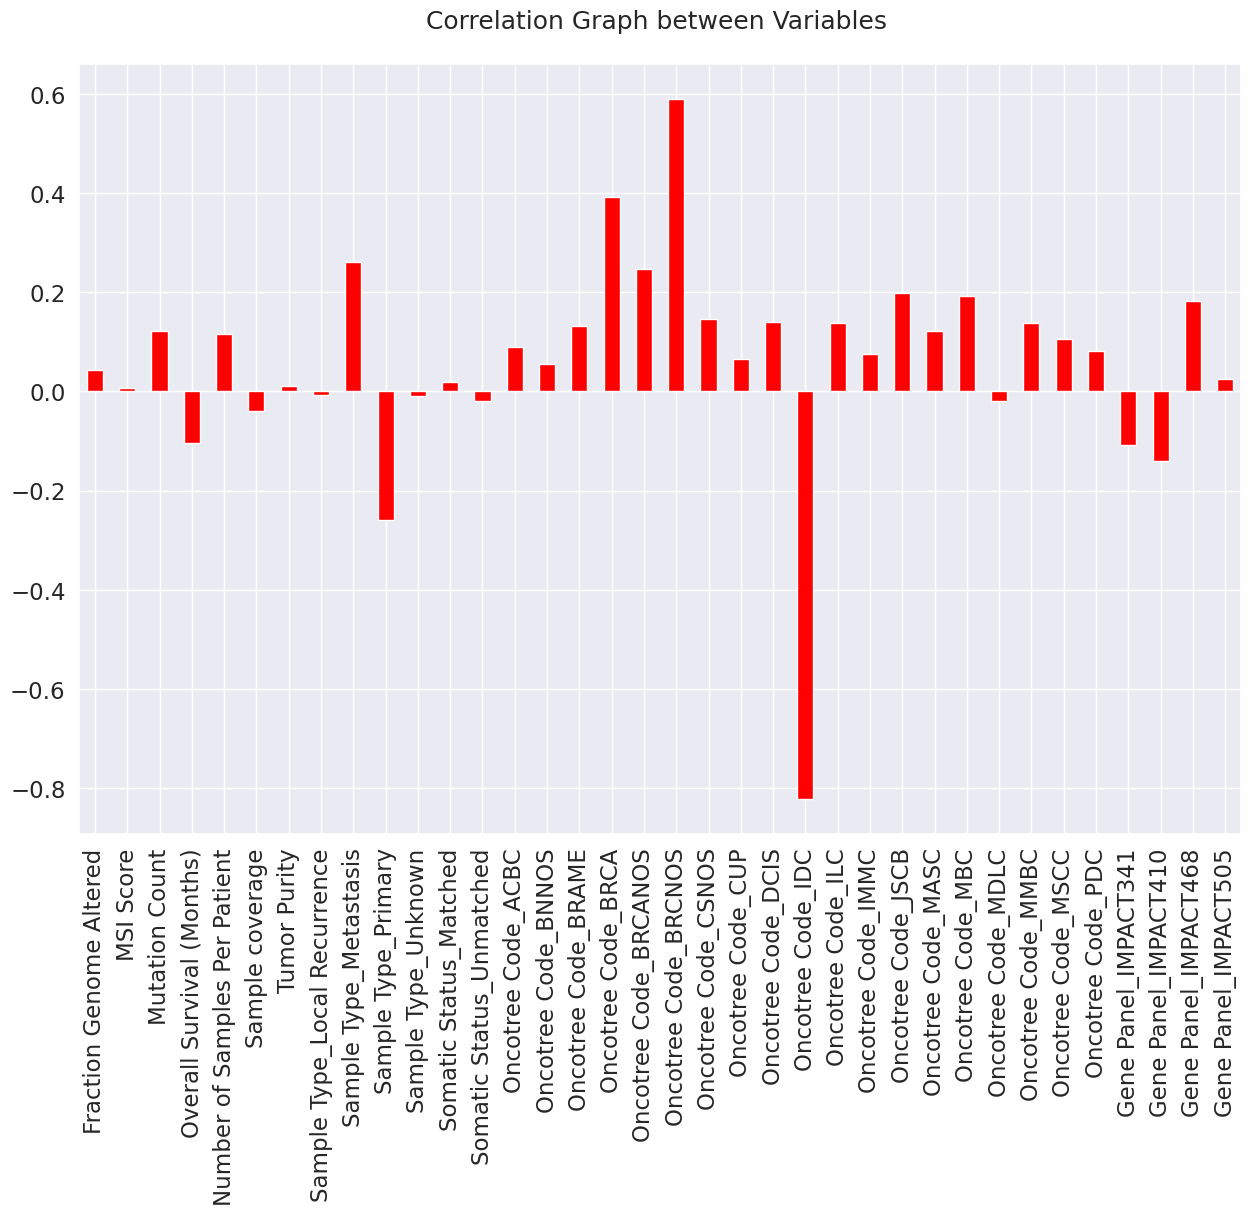

In [22]:
features = X_df.drop('target', axis=1)

correlation_with_diagnosis = features.corrwith(X_df['target'])
correlation_with_diagnosis.plot(kind='bar', grid=True, figsize=(15, 10), title="Correlation Graph between Variables \n", color="red")
plt.show()

#Model

In [50]:
batch_size=4
epochs=5
clusters=2
tree_model='Decision Tree'

Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.2,random_state=0)

In [24]:
def encode_target(y, target, num_classes=None):  # Add num_classes argument
    l_encode = LabelEncoder()
    l_encode.fit(y)  # Fit on the actual target values

    # Calculate num_classes if not provided
    if num_classes is None:
        num_classes = len(l_encode.classes_)

    Y = l_encode.transform(y)
    Y = to_categorical(Y, num_classes=num_classes)  # Specify num_classes
    return Y, l_encode  # Return the encoder as well

#Neuro Model Multclass

Epoch 1/5
775/775 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5023 - loss: 1.6955
Epoch 2/5
775/775 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8131 - loss: 0.5782
Epoch 3/5
775/775 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9005 - loss: 0.3300
Epoch 4/5
775/775 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9312 - loss: 0.2540
Epoch 5/5
775/775 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9316 - loss: 0.2136
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9496 - loss: 0.4254
Test Loss: 0.5235084891319275
Test Accuracy: 0.9432258009910583


F1 Score: 0.9483011649218896



                           feature  importance
22              Oncotree Code_IDC    0.341548
16             Oncotree Code_BRCA    0.077419
23              Oncotree Code_ILC    0.062194
18           Oncotree Code_BRCNOS    0.046710
17          Oncotree Code_BRCANOS    0.029935
28             Oncotree Code_MDLC    0.029290
30             Oncotree Code_MSCC    0.000

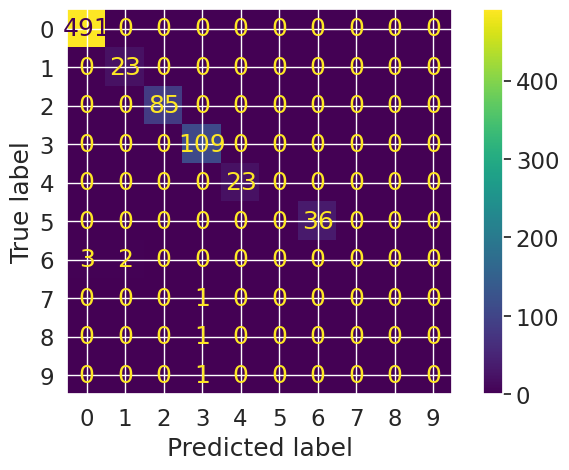

In [49]:
#Neural Network Multclass
# Get the total number of classes from the entire target (y)
all_target_classes = np.unique(np.concatenate([ytrain, ytest]))  # Or use y before splitting
num_classes = len(all_target_classes)

ytrain, l_encode_train = encode_target(ytrain, variavel, num_classes)
ytest, l_encode_test = encode_target(ytest, variavel, num_classes)

processor_Neuro = models_types(X=Xtrain,y=ytrain,Lista_variaveis=Lista_variaveis,batch_size=batch_size,epochs=epochs)
model = processor_Neuro.neuro_model_multiclass()

processor_Neuro.models_metrics_neuro_multiclass(model, Xtrain, ytrain, Xtest, ytest,l_encode_train,l_encode_test)

#Decission Tree MultClass

In [55]:
#Decission Tree

processor_decission_tree = models_types(X=Xtrain,y=ytrain,Lista_variaveis=Lista_variaveis,model_tree='Decission Tree')
model= processor_decission_tree.tree_and_random_forest()
model.fit(Xtrain, ytrain)
#processor_decission_tree.models_metrics(model, Xtrain, ytrain, Xtest, ytest)
#processor_decission_tree.models_metrics_random_tree(model, Xtrain, ytrain, Xtest, ytest)
#predition_1 = model.predict(Xtest)
#model_DecisionTree_acc = accuracy_score(ytest, predition_1)
#print("\nModel Accuracy: {:.2%}".format(model_DecisionTree_acc))

Best Parameters gini 12


DecisionTreeClassifier(max_depth=12)

In [56]:
from sklearn.metrics import accuracy_score
model_DecisionTree_acc = accuracy_score(ytest, model.predict(Xtest))
print("\nModel Accuracy: {:.2%}".format(model_DecisionTree_acc))


Model Accuracy: 99.74%


In [57]:
f1 = f1_score(ytest, model.predict(Xtest), average="weighted")
print("F1 Score: {:.2%}".format(f1))

F1 Score: 99.74%


Confussion Matrix


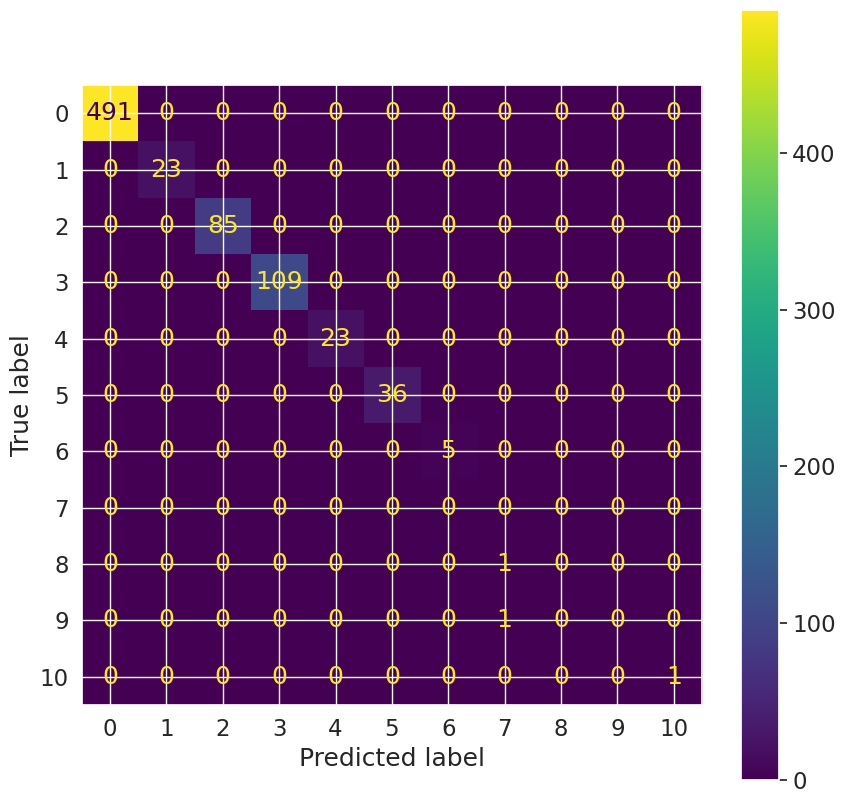

In [58]:
print('Confussion Matrix')
fig, ax = plt.subplots(figsize=(10, 10))
cmp = ConfusionMatrixDisplay(confusion_matrix(ytest, model.predict(Xtest)))
cmp.plot(ax=ax)
plt.show()

importance    36
dtype: int64


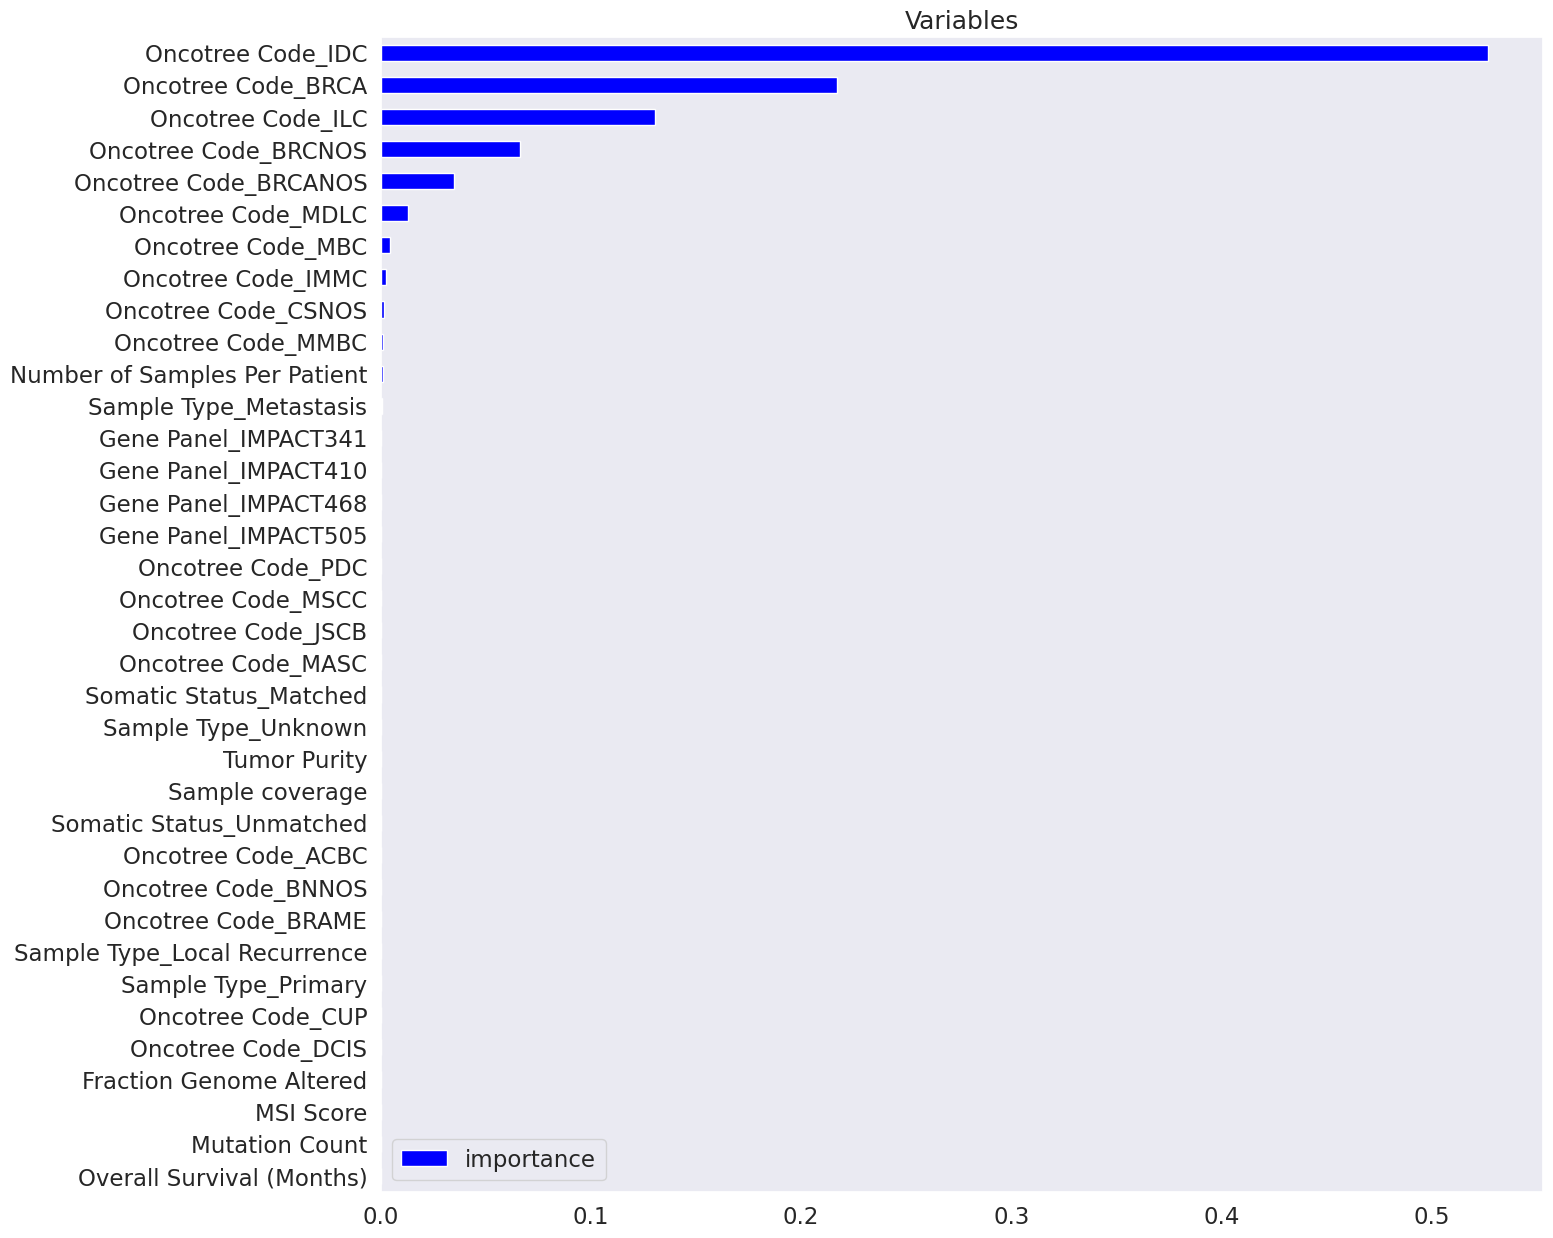

In [59]:
model.fit(Xtrain, ytrain)
    #I check how the variables behave in my model, whether they are good or not
    #this can help eliminate some variables and thus select a more precise group of information
feature_importances = pd.DataFrame(model.feature_importances_,
                                      index =Lista_variaveis,
                                        columns=['importance']).sort_values('importance',ascending=False)

print(feature_importances.count())

feat_imp_all = feature_importances.sort_values(ascending=True, by='importance')
graf_all = feat_imp_all.plot(kind = 'barh', color = 'blue', title='Variables', figsize=(15,15), grid = False )